In [1]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
# import os,sys
# from PIL import Image

from helpers import *
from sklearn import linear_model
from sklearn.metrics import confusion_matrix

%load_ext autoreload
%autoreload 2

In [2]:
from sklearn import metrics, cross_validation
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

from plots import cross_validation_visualization_f1score
from plots import cross_validation_visualization_rmse

c:\users\prisgdd\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
try: 
    import cv2
except: 
    import pip
    pip.main(['install', 'opencv-python'])
    import cv2 

In [4]:
# Loaded a set of images
root_dir = "training/"
image_dir = root_dir + "images/"
gt_dir = root_dir + "groundtruth/"

files = os.listdir(image_dir)

n = len(files)
imgs = [load_image(image_dir + files[i]) for i in range(n)]
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]

print("Loading " + str(n) + " satellite + ground truth images")

Loading 100 satellite + ground truth images


In [5]:
# # Reduce dataset for tests
# imgs = imgs[0:10]
# gt_imgs = gt_imgs[0:10]
# len(imgs)

In [6]:
seed = 3
np.random.seed(seed)
imgs = np.random.permutation(imgs)
gt_imgs = np.random.permutation(gt_imgs)

In [7]:
patch_size = 16

kf = KFold(n_splits = 10)
kf.get_n_splits(imgs)

10

In [8]:
import time

In [13]:
# Cs = np.arange(1e4, 1e4 + 1, 10000) 
lambdas = np.logspace(-5, 0, 8)
Cs = [np.ceil(1/lambda_) for lambda_ in lambdas]
# Cs = [5e4]
# C=[1e5]

acc_threshold =[]

accuracy_train_C = []
f1_score_train_C = []
mse_train_C = []
rmse_train_C = []

accuracy_test_C = []
f1_score_test_C = []
mse_test_C = []
rmse_test_C = []

accuracy_test_C_pp = []
f1_score_test_C_pp = []
mse_test_C_pp = []
rmse_test_C_pp = []

start_time_total = time.time()
for C in Cs:
    start_time_C = time.time()
    print("C = {}".format(C))

    accuracy_train_CV = []
    accuracy_test_CV = []
    mse_train_CV = []
    rmse_train_CV = []
    
    f1_score_train_CV = []
    f1_score_test_CV = []
    mse_test_CV = []
    rmse_test_CV = []
    
    accuracy_test_CV_pp = []
    f1_score_test_CV_pp = []
    mse_test_CV_pp = []
    rmse_test_CV_pp = []

    for ind, [train_index, test_index] in enumerate(kf.split(imgs)):

        #
        # Split dataset for Cross Validation
        #
        print("\n{}-th CV".format(ind+1))

        X_train = [imgs[ind] for ind in train_index]
        X_test = [imgs[ind] for ind in test_index]

        y_train = [gt_imgs[ind] for ind in train_index]
        y_test = [gt_imgs[ind] for ind in test_index]

        #
        # Crop images, extract features, features augmentation and standardization
        # For both train & test datasets
        # 
        X_train = [img_crop(X_train[i], patch_size, patch_size, step = 8) for i in range(len(train_index))]
        y_train = [img_crop(y_train[i], patch_size, patch_size, step = 8) for i in range(len(train_index))]
        X_test = [img_crop(X_test[i], patch_size, patch_size) for i in range(len(test_index))]
        y_test = [img_crop(y_test[i], patch_size, patch_size) for i in range(len(test_index))]        

        X_train = np.asarray([X_train[i][j] for i in range(len(X_train)) for j in range(len(X_train[i]))])
        X_test = np.asarray([X_test[i][j] for i in range(len(X_test)) for j in range(len(X_test[i]))])
        y_train = np.asarray([y_train[i][j] for i in range(len(y_train)) for j in range(len(y_train[i]))])
        y_test = np.asarray([y_test[i][j] for i in range(len(y_test)) for j in range(len(y_test[i]))])

        y_train = np.asarray([value_to_class(np.mean(y_train[i])) for i in range(y_train.shape[0])])
        y_test = np.asarray([value_to_class(np.mean(y_test[i])) for i in range(y_test.shape[0])])
#         print("Got all data in arrays!")

        # 
        # Balancing train data
        # 
        c0, c1 = 0, 0
        for i in range(len(y_train)):
            if y_train[i] == 0:
                c0 = c0 + 1
            else:
                c1 = c1 + 1
                
        min_c = min(c0, c1)
        idx0 = [i for i, j in enumerate(y_train) if j == 0]
        idx1 = [i for i, j in enumerate(y_train) if j == 1]
        new_indices = idx0[0:min_c] + idx1[0:min_c]
        X_train = X_train[new_indices]
        y_train = y_train[new_indices]
        
        
        
        X_train = np.asarray([ extract_features(X_train[i]) for i in range(len(X_train))])
#         X_train = features_augmentation(X_train)
        X_train -= np.mean(X_train)
#         X_train /= np.std(X_train, axis = 0)
#         print("Train data ready!")

        X_test = np.asarray([ extract_features(X_test[i]) for i in range(len(X_test))])
#         X_test = features_augmentation(X_test)
        X_test -= np.mean(X_test)
#         X_test /= np.std(X_test, axis = 0)
#         print("Test data ready!")
        print("All data balanced and ready!")

        # 
        # Run logistic regression 
        # 
        logreg = linear_model.LogisticRegression(C=C, class_weight="balanced")
        logreg.fit(X_train, y_train)
#         print("Model fitted!")
        z_train = logreg.predict(X_train)
        z_test = logreg.predict(X_test)

        # 
        # Compute f1 score & accuracy using sklearn functions
        # 
        f1_score_train = f1_score(y_train, z_train, average='micro')
        accuracy_score_train = accuracy_score(y_train, z_train)
        mse_train = mean_squared_error(y_train, z_train)
        rmse_train = np.sqrt(mean_squared_error(y_train, z_train))
        
        f1_score_test = f1_score(y_test, z_test, average='macro')
        accuracy_score_test = accuracy_score(y_test, z_test)
        mse_test = mean_squared_error(y_test, z_test)
        rmse_test = np.sqrt(mean_squared_error(y_test, z_test))
        
        print("Train f1_score : {}".format(f1_score_train))
        print("Test f1_score : {}".format(f1_score_test))
        
        
        # 
        # Post processing on test dataset
        # 
        
        # Reshape prediction as matrix for each image
        z_reshaped = []
        num_patch_total = len(z_test)
        num_patch_by_img = num_patch_total // len(test_index)
        
        for i in range(0, num_patch_total, num_patch_by_img):
            z_crt = z_test[i : i + num_patch_by_img]
            z_reshaped.append(np.reshape(z_crt, [400 // 16, 400 // 16]))

        # Run post process 
        for ind, label_img in enumerate(z_reshaped):
            label_img = postprocess(label_img)
            z_reshaped[ind] = np.reshape(label_img, [z_crt.shape[0]])

        # Convert list as array
        z_test_pp = np.concatenate( z_reshaped , axis = 0 )
#         print("Postprocessing done!")

        f1_score_test_pp = f1_score(y_test, z_test_pp, average='micro')
        accuracy_score_test_pp = accuracy_score(y_test, z_test_pp)
        mse_test_pp = mean_squared_error(y_test, z_test_pp)
        rmse_test_pp = np.sqrt(mean_squared_error(y_test, z_test_pp))
        
        print("Test f1_score post processed : {}\n".format(f1_score_test_pp))
        
        # 
        # Store accuracy for train, test and test+PP
        # 
        f1_score_train_CV.append(f1_score_train)
        accuracy_train_CV.append(accuracy_score_train)
        mse_train_CV.append(mse_train)
        rmse_train_CV.append(rmse_train)

        f1_score_test_CV.append(f1_score_test)
        accuracy_test_CV.append(accuracy_score_test)
        mse_test_CV.append(mse_test)
        rmse_test_CV.append(rmse_test)
        
        f1_score_test_CV_pp.append(f1_score_test_pp)
        accuracy_test_CV_pp.append(accuracy_score_test_pp)
        mse_test_CV_pp.append(mse_test_pp)
        rmse_test_CV_pp.append(rmse_test_pp)
    

    print("Average train F1-score: {}".format(np.mean(f1_score_train_CV)))
    
    print("Average test F1-score: {}".format(np.mean(f1_score_test_CV)))
    print("Variance test F1-score: {}".format(np.std(f1_score_test_CV)))
    print("Min test F1-score: {} // Max test F1-score: {}\n".format(np.min(f1_score_test_CV), np.max(f1_score_test_CV)))
    
    print("Average test F1-score PP: {}".format(np.mean(f1_score_test_CV_pp)))
    print("Variance test F1-score PP: {}".format(np.std(f1_score_test_CV_pp)))
    print("Min test F1-score PP: {} // Max test F1-score PP: {}\n".format(np.min(f1_score_test_CV_pp), np.max(f1_score_test_CV_pp)))
    
    accuracy_train_C.append(np.mean(accuracy_train_CV))
    f1_score_train_C.append(np.mean(f1_score_train_CV))
    mse_train_C.append(np.mean(mse_train_CV))
    rmse_train_C.append(np.mean(rmse_train_CV))

    accuracy_test_C.append(np.mean(accuracy_test_CV))
    f1_score_test_C.append(np.mean(f1_score_test_CV))
    mse_test_C.append(np.mean(mse_test_CV))
    rmse_test_C.append(np.mean(rmse_test_CV))
    
    accuracy_test_C_pp.append(np.mean(accuracy_test_CV_pp))
    f1_score_test_C_pp.append(np.mean(f1_score_test_CV_pp))
    mse_test_C_pp.append(np.mean(mse_test_CV_pp))
    rmse_test_C_pp.append(np.mean(rmse_test_CV_pp))
    
    
    print("Time for C = %s --- %s seconds --- \n\n" % (C, time.time() - start_time_C))
print("Total time --- %s seconds --- \n\n" % (time.time() - start_time_total))
        

C = 100000.0

1-th CV
All data balanced and ready!


c:\users\prisgdd\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Train f1_score : 0.5300958653746681
Test f1_score : 0.4289629968021928
Test f1_score post processed : 0.7512


2-th CV
All data balanced and ready!
Train f1_score : 0.5231378978146602
Test f1_score : 0.4429093502094661
Test f1_score post processed : 0.79504


3-th CV
All data balanced and ready!
Train f1_score : 0.5306354399862235
Test f1_score : 0.49890624281390783
Test f1_score post processed : 0.67552


4-th CV
All data balanced and ready!
Train f1_score : 0.514439401288892
Test f1_score : 0.2045309914725722
Test f1_score post processed : 0.25808


5-th CV
All data balanced and ready!
Train f1_score : 0.517341448354944
Test f1_score : 0.22944149919861917
Test f1_score post processed : 0.2984


6-th CV
All data balanced and ready!
Train f1_score : 0.5185106608677204
Test f1_score : 0.2324696057963895
Test f1_score post processed : 0.30384


7-th CV
All data balanced and ready!
Train f1_score : 0.5207342475264711
Test f1_score : 0.44010653580634324
Test f1_score post processed : 0.454

All data balanced and ready!
Train f1_score : 0.5182499779483108
Test f1_score : 0.22944149919861917
Test f1_score post processed : 0.2984


6-th CV
All data balanced and ready!
Train f1_score : 0.5182454651532831
Test f1_score : 0.2324696057963895
Test f1_score post processed : 0.30384


7-th CV
All data balanced and ready!
Train f1_score : 0.5203957646241972
Test f1_score : 0.4806416077809721
Test f1_score post processed : 0.70128


8-th CV
All data balanced and ready!
Train f1_score : 0.5200396790866849
Test f1_score : 0.4616200192972995
Test f1_score post processed : 0.7224


9-th CV
All data balanced and ready!
Train f1_score : 0.5126691670843632
Test f1_score : 0.2095656697676434
Test f1_score post processed : 0.2584


10-th CV
All data balanced and ready!
Train f1_score : 0.5154892330940688
Test f1_score : 0.19114792286786592
Test f1_score post processed : 0.2376

Average train F1-score: 0.520225367003212
Average test F1-score: 0.3317349624833404
Variance test F1-score: 0.119533

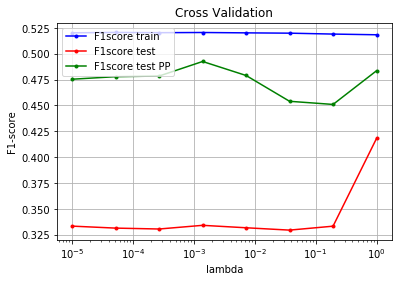

In [14]:
cross_validation_visualization_f1score(lambdas, f1_score_train_C, f1_score_test_C, f1_score_test_C_pp)

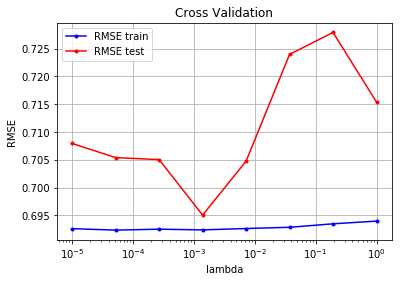

In [16]:
cross_validation_visualization_rmse(lambdas, rmse_train_C, rmse_test_C)